Kornpob Bhirombhakdi, kbhirombhakdi@stsci.edu

# Story
We would like to estimate contamination of X01 on GRB 190829A. To do this, the flow is laid out in KB's scrapbook. In summary:

## Method 1
- Use GrismApCorr table to determine light collected inside halfdyX aperture, and outside. (Note: halfdyX = extraction aperture of X01 which will not be a free variable, and will be determined by halfdyG = extraction aperture of GRB. That is halfdyG will determine which part of X01 would be considered inside and outside. Let's call grismapcorr_halfdyX_in and grismapcorr_halfdyX_out where grismapcorr_halfdyX_in + grismapcorr_halfdyX_out = 1.
- Starting from spectral profile of X01 (i.e., wavelength, flam), 
 - transform it into (xg,flam_xg) where xg is pixel location on dispersion axis (i.e., x axis for WFC3) in GRB's frame. This would require X01 trace (xg,yg,wavelength_xg_yg) on GRB frame, and discretize the spectral profile. Also, the spectral profile is assumed to be re-calibrated back to GRB frame (e.g., reddening, zshift, vpec, etc.).
 - transform flam_xg to cps_xg = flam_xg * sensitivity_xg * wwperpix_xg where sensitivity_xg is discretized sensitivity_wavelength and wwperpix_xg is straigthforward.
 - compute cps_xg
 - (to be continued)
 
## Method 2
- Use GrismApCorr table to bake a pixel-wise correction. This will give a 2D array of (wavelength, pixel distance along cross dispersion from trace, light collected in the pixel). Let's call this table... grism_bucket.
- Set common wavelength grid of X01 by using GRB frame.
- Interpolate to common X01 wavelength for both pixel-wise correction and spectral profile.
- Use halfdy of GRB to determine the contamination region.
- Map contamination region back to pixel-wise correction to determine contamination fraction.
- Convolve contamination fraction with spectral profile to get contaminating flam.
- Convert contaminating flam to contaminating cps.
- Extract GRB cps and subtract contaminating cps to get contamination-free GRB cps.
- Perform the rest of calibration with contamination-free GRB cps to get contamination-free GRB flam.

# Note
- We perform contamination removal on cps space, not flam space.
- Benefit of Method 2 over 1 is that we get 2D array of pixel response from the baked pixel-wise correction which can be used for other tasks such as 

# Assumptions
- X01 contamination is not removed by background estimation. To do this, regions with X01 contribution must be masked out from the estimation.
- X01 spectral profile must be re-calibrated into GRB frame. Given our flow, this should be satisfied without additional process because we extracted X01 from 201911 and 202001 frames without dereddening or de-redshift. Since X01 and GRB locates approximately at the same WCS across observations from 201909 to 202002, we can assume that X01 profile from 201911-202001 is directly applicable to other nearby epochs.
- We assume that flatfields across different frames have negligible effects.

# What is this file?
We will try Method 2. First, we will focus on making grism_bucket.


In [1]:
from hstgrism.grismapcorr import GrismApCorr
import numpy as np
import matplotlib.pyplot as plt


In [6]:
g102_tab = GrismApCorr().table['HST-WFC3-IR-G102']
g102_tab


{'ref': 'ISR WFC3-2011-05',
 'filter': 'G102',
 'scale': 0.13,
 'scaleunit': 'arcsec/pix',
 'type': 'diameter',
 'row': 'apsize',
 'col': 'wave',
 'apunit': 'arcsec',
 'apsize': array([ 0.128,  0.385,  0.641,  0.898,  1.154,  1.411,  1.667,  1.924,
         3.719,  7.567, 12.954, 25.779]),
 'waveunit': 'A',
 'wave': array([ 8850.,  9350.,  9850., 10350., 10850., 11350.]),
 'value': array([[0.459, 0.391, 0.414, 0.464, 0.416, 0.369],
        [0.825, 0.809, 0.808, 0.811, 0.794, 0.792],
        [0.89 , 0.889, 0.887, 0.88 , 0.875, 0.888],
        [0.92 , 0.917, 0.916, 0.909, 0.904, 0.916],
        [0.939, 0.937, 0.936, 0.93 , 0.925, 0.936],
        [0.952, 0.95 , 0.95 , 0.943, 0.94 , 0.949],
        [0.962, 0.961, 0.961, 0.954, 0.951, 0.958],
        [0.969, 0.968, 0.969, 0.962, 0.959, 0.965],
        [0.985, 0.984, 0.986, 0.982, 0.98 , 0.983],
        [0.995, 0.995, 0.996, 0.991, 0.99 , 0.992],
        [0.999, 0.999, 0.999, 0.997, 0.996, 0.995],
        [1.   , 1.   , 1.   , 1.   , 1.   , 

In [30]:
apsize_pix = g102_tab['apsize'] / g102_tab['scale']
apsize_pix = apsize_pix.round()
apsize_pix


array([  1.,   3.,   5.,   7.,   9.,  11.,  13.,  15.,  29.,  58., 100.,
       198.])

In [31]:
wavelength = g102_tab['wave'].copy()
apcorr = g102_tab['value'].copy()

Text(0.5, 1.0, 'apcorr')

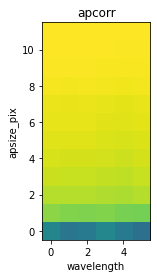

In [34]:
plt.imshow(apcorr,origin='lower',cmap='viridis',vmin=0,vmax=1)
plt.xlabel('wavelength')
plt.ylabel('apsize_pix')
plt.title('apcorr')


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x11a27c810>)

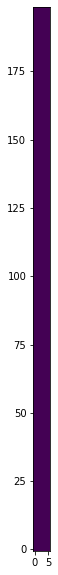

In [48]:
ny,nx = int(apsize_pix.max()+1),len(wavelength)
shape = (ny,nx)
grism_bucket = np.zeros(shape)
plt.figure(figsize=(10,10)),plt.imshow(grism_bucket,origin='lower')


In [47]:
for ii,i in enumerate(wavelength):
    if ii!=0:
        continue
    t = apcorr[:,ii]
    for jj,j in enumerate(t):
        print(ii,i,jj,j)
    

0 8850.0 0 0.459
0 8850.0 1 0.825
0 8850.0 2 0.89
0 8850.0 3 0.92
0 8850.0 4 0.939
0 8850.0 5 0.952
0 8850.0 6 0.962
0 8850.0 7 0.969
0 8850.0 8 0.985
0 8850.0 9 0.995
0 8850.0 10 0.999
0 8850.0 11 1.0


# EoD
We will continue this tomorrow :)